In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

import schedulefree

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

# Penalty Loss Function

We want to punish the network for computing biases that lead to a large absolute error, but want to allow it to have a small error for many points.

We keep the quadratic term in the loss, s.t. we can have smooth learning in the beginning and then slowly ramp up the penalty term.

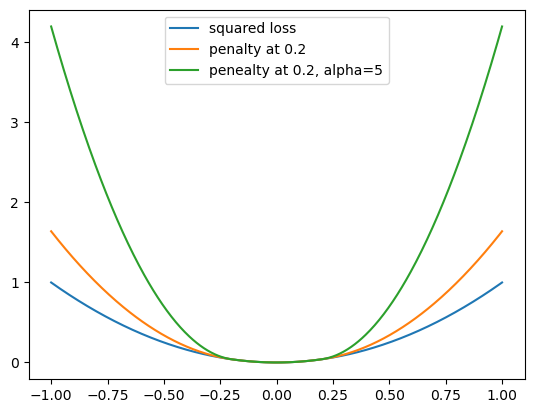

In [22]:
def foo(x, penalty_tresh=0.5, alpha=1): return x**2 + alpha * (torch.relu(x - penalty_tresh)**2 + torch.relu(-penalty_tresh - x)**2)

x = torch.linspace(-1, 1, 500)
y = foo(x, penalty_tresh=1)
y2 = foo(x, penalty_tresh=0.2)
y5 = foo(x, penalty_tresh=0.2, alpha=5)
plt.plot(x, y, label="squared loss")
plt.plot(x, y2, label="penalty at 0.2")
plt.plot(x, y5, label="penealty at 0.2, alpha=5")
plt.legend()
plt.show()

In [23]:
def penalty_loss(y_hat, y, penalty_tresh=1, alpha=0):
    diff = y - y_hat
    return (diff**2 + alpha * (torch.relu(diff - penalty_tresh)**2 + torch.relu(-penalty_tresh - diff)**2)).mean()

In [29]:
print(penalty_loss(torch.tensor([0.]), torch.tensor([0.]), penalty_tresh=1, alpha=1))
print(penalty_loss(torch.tensor([2.]), torch.tensor([1.]), penalty_tresh=0, alpha=1))

tensor(0.)
tensor(2.)


# Training Loop

In [58]:
def train_loop(net, train_dataloader, val_dataloader, alpha_penalty=1, penalty_tresh_discount=0.9, start_penalty_epoch=1, lossfun=nn.MSELoss(), patience=10, num_epochs=100, timeout=60, opt='adam', l1_weight=0):   
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters())
    elif opt == 'schedulefree':
        optimizer = schedulefree.AdamWScheduleFree(net.parameters(), lr=0.0025)
    else:
        raise ValueError('Uknown optimizer!')

    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    val_maxs = []
    best_val_loss = float('inf')
    early_stopping_cnt = 0
    t_start = time.time()
    for epoch in range(num_epochs):
        t_cur = time.time()
        if t_cur - t_start > timeout:
            print(f"Timeout reached ({t_cur - t_start} sec)")
            break 
        
        net.train()

        if opt == 'schedulefree':
            optimizer.train()

        if epoch < start_penalty_epoch:
            alpha = 0
            penalty_tresh = 1
        else:
            alpha = alpha_penalty
            penalty_tresh = penalty_tresh_discount * min(val_maxs)
            print(f"### penalty_tresh: {penalty_tresh}, alpha: {alpha}")

        train_loss = 0.
        train_mae = 0.
        train_standard_loss = 0.
        train_penalty_loss = 0.
        penalty_count = 0
        for batch_X, batch_y in train_dataloader:
            y_hat = net(batch_X)
            #loss = penalty_loss(y_hat, batch_y, alpha=alpha, penalty_tresh=penalty_tresh)
            loss = 0
            standard_loss = lossfun(y_hat, batch_y)
            loss += standard_loss

            penalty_loss = alpha * (torch.relu((batch_y - y_hat) - penalty_tresh)**2 + torch.relu(-penalty_tresh - (batch_y - y_hat))**2).mean()
            penalty_count += ((torch.relu((batch_y - y_hat) - penalty_tresh) > 0) + (torch.relu(-penalty_tresh - (batch_y - y_hat)) > 0)).sum().item()
            loss += penalty_loss

            l1_loss = 0
            for param in net.parameters():
                l1_loss += param.abs().sum()

            loss += l1_weight * l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_standard_loss += standard_loss.item()
            train_penalty_loss += penalty_loss.item()
            train_mae += torch.abs(y_hat - batch_y).mean().item()

        train_loss /= len(train_dataloader)
        train_standard_loss /= len(train_dataloader)
        train_penalty_loss /= len(train_dataloader)
        train_mae /= len(train_dataloader)
        train_losses.append(train_loss)
        train_maes.append(train_mae)


        net.eval()

        if opt == 'schedulefree':
            optimizer.eval()
            
        val_loss = 0
        val_mae = 0
        val_max = torch.tensor(0)
        with torch.no_grad():
            for batch_X, batch_y in val_dataloader:
                y_hat = net(batch_X)
                #loss = penalty_loss(y_hat, batch_y, alpha=alpha, penalty_tresh=penalty_tresh)
                loss = lossfun(y_hat, batch_y)
                val_loss += loss.item()
                val_mae += torch.abs(y_hat - batch_y).mean().item()
                val_max = torch.maximum(val_max, torch.max(F.relu(batch_y - y_hat)))

        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        val_maxs.append(val_max.item())

        print(f"Epoch [{epoch + 1}/{num_epochs}] - train_loss: {train_loss:.6f}, train_standard_loss: {train_standard_loss:.6}, train_penalty_loss: {train_penalty_loss:.6f}, penalty_count: {penalty_count}, val_loss: {val_loss:.6f}, val_max: {val_max.item():.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_cnt = 0
            best_net_state = net.state_dict()
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= patience:
                print(f"Stopping early (patience of {patience} reached)")
                break


    print("Training completed")
    return train_losses, val_losses, train_maes, val_maes, val_maxs, best_net_state

In [32]:
def make_nn(n_neurons, h, w):
    net = torch.nn.Sequential(torch.nn.Flatten(), 
                              torch.nn.Linear(3*h*w, n_neurons),     torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                              torch.nn.Linear(n_neurons, 1))
    return net

# Training

In [33]:
ds_train = torch.load('./datasets/maxpool2x2_train_clean.pth')
ds_val   = torch.load('./datasets/maxpool2x2_val_clean.pth')

In [35]:
subset_idxs = torch.randperm(len(ds_train))[:100000]
ds_small_train = Subset(ds_train, subset_idxs)

In [36]:
batch_size = 32
train_dataloader = DataLoader(ds_small_train, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(ds_val, batch_size=batch_size)

In [47]:
net = make_nn(50, 2, 2)
train_losses, val_losses, train_maes, val_maes, val_maxs, best_state = train_loop(net, train_dataloader, val_dataloader, timeout=300, 
                                                                                  alpha_penalty=3, start_penalty_epoch=5, penalty_tresh_discount=0.99,
                                                                                  patience=25, num_epochs=1000, l1_weight=0)

Epoch [1/1000] - train_loss: 0.006979, train_penalty_loss: 0.000000, val_loss: 0.001101, val_max: 0.169598
Epoch [2/1000] - train_loss: 0.000930, train_penalty_loss: 0.000000, val_loss: 0.000648, val_max: 0.172316
Epoch [3/1000] - train_loss: 0.000641, train_penalty_loss: 0.000000, val_loss: 0.000430, val_max: 0.198307
Epoch [4/1000] - train_loss: 0.000512, train_penalty_loss: 0.000000, val_loss: 0.000443, val_max: 0.178305
Epoch [5/1000] - train_loss: 0.000413, train_penalty_loss: 0.000000, val_loss: 0.000295, val_max: 0.143981
### penalty_tresh: 0.14254100784659385, alpha: 3
Epoch [6/1000] - train_loss: 0.000355, train_penalty_loss: 0.000000, val_loss: 0.000243, val_max: 0.113254
### penalty_tresh: 0.1121214410662651, alpha: 3
Epoch [7/1000] - train_loss: 0.000328, train_penalty_loss: 0.000000, val_loss: 0.000649, val_max: 0.132816
### penalty_tresh: 0.1121214410662651, alpha: 3
Epoch [8/1000] - train_loss: 0.000290, train_penalty_loss: 0.000000, val_loss: 0.000302, val_max: 0.118660

KeyboardInterrupt: 

In [64]:
train_losses_list = []
val_losses_list = []
val_maxs_list = []
best_states = []

for penalty_tresh_discount in [0.5]:
    for alpha_penalty in [0, 5000, 7500, 10000]:
        print(f"### penalty_tresh_discount: {penalty_tresh_discount}, alpha_penalty: {alpha_penalty}")
        net = make_nn(50, 2, 2)
        train_losses, val_losses, train_maes, val_maes, val_maxs, best_state = train_loop(net, train_dataloader, val_dataloader, timeout=900, 
                                                                                              alpha_penalty=alpha_penalty, start_penalty_epoch=5, penalty_tresh_discount=penalty_tresh_discount,
                                                                                              patience=25, num_epochs=1000, l1_weight=0)
        train_losses_list.append(train_losses)
        val_losses_list.append(val_losses)
        val_maxs_list.append(val_maxs)
        best_states.append(best_state)
            

### penalty_tresh_discount: 0.5, alpha_penalty: 0
Epoch [1/1000] - train_loss: 0.007265, train_standard_loss: 0.00726548, train_penalty_loss: 0.000000, penalty_count: 8, val_loss: 0.001352, val_max: 0.202223
Epoch [2/1000] - train_loss: 0.000922, train_standard_loss: 0.000922383, train_penalty_loss: 0.000000, penalty_count: 0, val_loss: 0.000559, val_max: 0.135626
Epoch [3/1000] - train_loss: 0.000596, train_standard_loss: 0.000596041, train_penalty_loss: 0.000000, penalty_count: 0, val_loss: 0.000719, val_max: 0.141433
Epoch [4/1000] - train_loss: 0.000465, train_standard_loss: 0.000465151, train_penalty_loss: 0.000000, penalty_count: 0, val_loss: 0.000408, val_max: 0.118684
Epoch [5/1000] - train_loss: 0.000376, train_standard_loss: 0.000376364, train_penalty_loss: 0.000000, penalty_count: 0, val_loss: 0.000411, val_max: 0.124615
### penalty_tresh: 0.059341996908187866, alpha: 0
Epoch [6/1000] - train_loss: 0.000333, train_standard_loss: 0.000332747, train_penalty_loss: 0.000000, pen

# Analyze Data

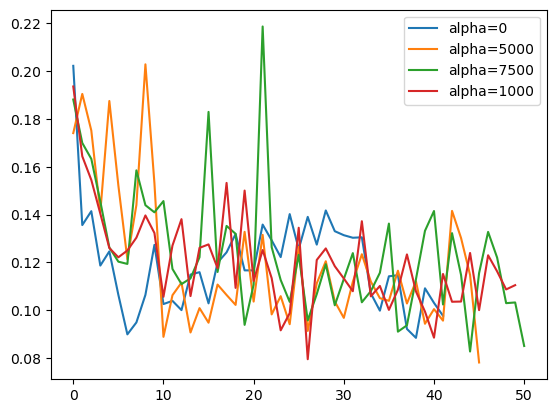

In [66]:
for alpha, val_maxs in zip([0, 5000, 7500, 1000], val_maxs_list):
    plt.plot(val_maxs, label=f"alpha={alpha}")
plt.legend()
plt.show()